#신경망 모델 훈련 

1. 손실곡선 

In [23]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [24]:
from tensorflow import keras 
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input/255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size =0.2, random_state = 42
)

In [25]:
def model_fn(a_layer = None):
  model= keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model 

if 구문의 역할은 model_fn()함수에 (a_layer 매개변수로) 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 것임

In [26]:
# model_fn()함수를 호출 

model= model_fn()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [27]:
#fit() 메서드의 결과를 history 변수에 담기 

model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [28]:
#history에 어떤 값이 들어있는지 확인 

print(history.history.keys())

dict_keys(['loss', 'accuracy'])


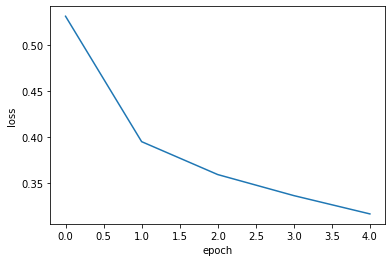

In [29]:
#그래프로 표현 

import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

파이썬 리스트의 인덱스는 0부터 시작하므로 5개의 에포크가 0에서부터 4까지 x축에 표현됨

y축은 계산된 손실 값을 말한다

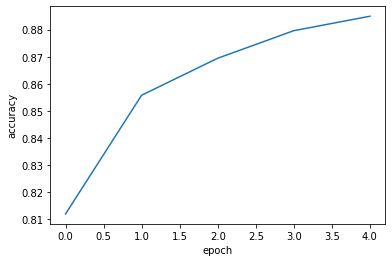

In [30]:
#정확도를 출력 


plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

에포크 마다 손실이 감소하고 정확도가 향상한다

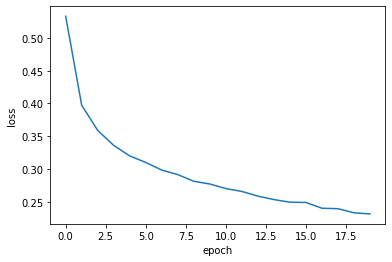

In [31]:
#에포크 횟수를 20으로 늘려서 모델을 훈련, 손실 그래프를 그려보기 
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

예상대로 손실이 잘 감소한다는 것을 알 수 있었음 

2. 검증손실

In [32]:

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [33]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


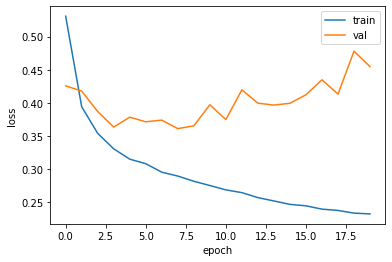

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련손실은 꾸준히 감소하므로 전형적인 과대적합 모델이 만들어진다. 

검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다.

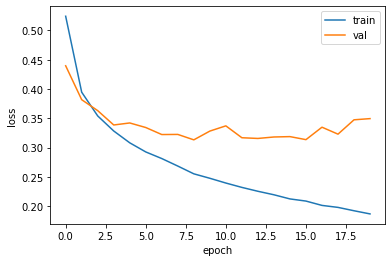

In [35]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대 적합이 훨씬 줄었다는 것을 확인할 수 있음 



3. 드롭아웃 

model_fn()함수에 드롭아웃 객체를 전달하여 층을 추가하는데 30%정도를 드롭아웃한다.

In [40]:
model = model_fn(keras.layers.Dropout(0.3))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               78500     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

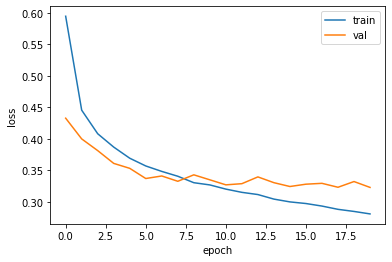

In [42]:
#모델을 평가와 예측할 때는 자동으로 드롭아웃을 적용하지 않는다 

#훈련손실과 검증손실의 그래프를 그려서 비교해보기 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

4. 모델 저장과 복원 

모델 에포크 횟수를 10으로 다시 지정하고 모델을 훈련 

In [43]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

모델을 저장하기 

In [44]:
#1 

model.save_weights('model-weights.h5')

In [45]:
#2 

model.save('model-whole.h5')

In [47]:
#두 파일이 잘 만들어졌는지 확인 

!ls -al *.h5

-rw-r--r-- 1 root root 333448 Aug 17 16:52 model-weights.h5
-rw-r--r-- 1 root root 982664 Aug 17 16:54 model-whole.h5


훈련하지 않은 새로운 모델을 만들고 model-weight.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용

In [48]:
model= model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

model-whole.h5 파일에서 새로운 모델을 만들어 바로 사용함

In [49]:
#모델의 검증 정확도 확인하기 

import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels== val_target))

0.8803333333333333


모델의 predict() 메서드 결과 큰 값을 고르기 위해 argmax()함수를 사용하였음 

argmax()함수의 axis=-1은 배열의 마지막 차원을 따라 최댓값을 고름 

그 다음 라인은 argmax()로 고른 인덱스(val_labels)와 타깃(val_target)을 비교한다 

두 배열에서 각 위치의 값이 같으면 1, 다르면 0이 되는데 이를 평균하면 정확도가 됨

In [50]:
#모델 전체를 파일에서 읽은 다음 검증 세트의 정확도를 출력 


model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3271 - accuracy: 0.8803


[0.3271023631095886, 0.8803333044052124]

5. 콜백 

modelcheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다. save_best_only=True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있음 


'best-model.h5'로 지정하여 콜백을 적용 

In [52]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

model_fn()함수로 모델을 만들고 compile() 메서드를 호출하는 것은 이전과 동일.

ModelCheckpoint 클래스의 객체 checkpoint_cb를 만든 후 fit()메서드의 callbacks 매개변수에 리스트로 감싸서 전달한다 



In [53]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3153 - accuracy: 0.8863


[0.3152652084827423, 0.8863333463668823]

6. 조기종료 

EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있고 또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다 

In [54]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [55]:
print(early_stopping_cb.stopped_epoch)

9


10번째 에포크에서 훈련이 중지되었다는 것을 알 수 있고 최상의 모델은 8번째 에포크이다. 

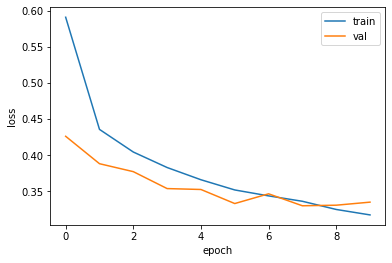

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능을 확인해보기 

In [57]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3298 - accuracy: 0.8809


[0.3297530710697174, 0.8809166550636292]